In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20250228-213124_continuous.json'

tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2025-08-03 17:48:47,950 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))
#kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated_no_reg.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [3]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

In [4]:
# Load TFA samples 
import pandas as pd
import numpy as np
tfa_sample_file = 'reduced_model_ETC_core_20250228-213124_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)


faraday_const = 23.061 # kcal / mol / V
RT = tmodel.RT # kcal /mol
delta_psi_scaled = 150/1000 * faraday_const / RT  # mV * F / RT 

# Psuedo data for the membrane potential
tfa_samples['psi_m_c'] = delta_psi_scaled * 1e-3 # be aware of the scaling!!!
tfa_samples['MitoMembranePot_in'] = 1000 # ~ 1000 RT/min -> at 5 RT is equivalent to about 2 min time scale for the membrane potential
tfa_samples['MitoMembranePot_out'] = 1000

# 30 min timescale for insulin action 
tfa_samples['Insulin_secretion'] = 1/30 / flux_scaling_factor
tfa_samples['Insulin_degradation'] = 1/30 / flux_scaling_factor
tfa_samples['insulin_e'] = 1e-3 

additional_fluxes = ['MitoMembranePot_in','MitoMembranePot_out', 'Insulin_secretion', 'Insulin_degradation',]
additional_concentrations = ['psi_m_c', 'insulin_e']


<Axes: ylabel='Frequency'>

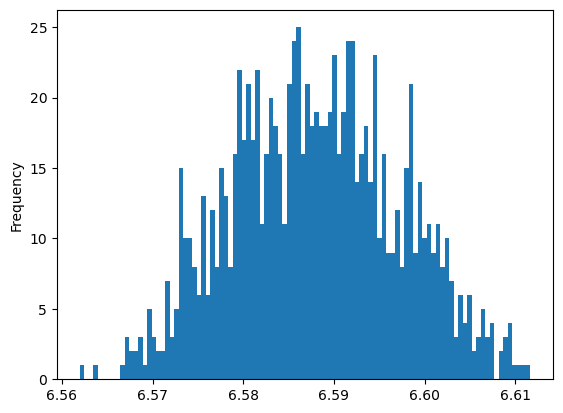

In [5]:
(tfa_samples['cyt_atp2adp'] * 1.2).plot.hist(bins=100) 

In [6]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))
#parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters_no_reg.hdf5'))

In [7]:
# Prepare the model to run an ODE simulaiton
kmodel.compile_ode(ncpu=NCPU)

In [8]:
# Get stoichiometric matrix
from skimpy.utils.general import get_stoichiometry
S = get_stoichiometry(kmodel, kmodel.reactants).todense()


In [9]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [10]:
from skimpy.core.parameters import ParameterValues
from skimpy.analysis.oracle import load_concentrations

from tqdm import tqdm

# Function for population analysis
def steady_state_perturbation(parameter, range=np.logspace(-1,1,51,base=10) , 
                            additional_parameter_changes={},
                            time = [0, 500], 
                            parameter_population=parameter_population, 
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            end_ix=-1,
                            ):
    
    # List of dataframes
    results = []

    # Run the perturbation for each parameterset
    parameter_population_index = list(parameter_population._index.keys())
    
    for parameter_set_id in tqdm(parameter_population_index[:end_ix]):

        # This will be a list of dataframes
        this_results = []

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING,
                                            additional_concentrations=additional_concentrations)

        for k in kmodel.initial_conditions:
                kmodel.initial_conditions[k] = concentrations[k]

        # Load the parameter values 
        kmodel.parameters = parameter_population[parameter_set_id]

        # Integrate additional parameters changes (fold changes)
        for k, v in additional_parameter_changes.items():
            kmodel.parameters[k].value = kmodel.parameters[k].value * v

        # Perturb the main parameter
        if parameter == 'fuel':
            fuels = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e', ]
            p0 = [ kmodel.parameters[f].value for f in fuels]
        else:
            p0 = kmodel.parameters[parameter].value
        
        for perturbation_value in range:
            if parameter == 'fuel':
                for f, v in zip(fuels, p0):
                    kmodel.parameters[f].value = perturbation_value * v
            else:
                kmodel.parameters[parameter].value = perturbation_value * p0
            # Dynamic solution            
            sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9, rtol=1e-6)
            # Get steady state concentrations
            steady_state_concentrations = sol.concentrations.iloc[-1]

            # Compute the fluxes at steady state
            # Get parameters value set 
            parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
            parameter_values = ParameterValues(parameter_values, kmodel)

            steady_state_fluxes = pd.Series(flux_function(steady_state_concentrations, parameters=parameter_values), 
                                            index=kmodel.reactions.keys())
            
            # Check if fluxes are approximetly at  steady state
            dxdt = (S @ steady_state_fluxes[kmodel.reactions.keys()]) 
            is_steady_state = np.all(abs(dxdt) < 1e-2)

            #print(is_steady_state)

            # Add the results to a dataframe 
            steady_state_output = pd.concat([steady_state_concentrations, steady_state_fluxes])

            # Add metadata 
            steady_state_output['pertubration'] = perturbation_value
            steady_state_output['parameter_set'] = parameter_set_id
            steady_state_output['parameter'] = parameter    
            steady_state_output['aditional_parameters'] = [f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()]
            steady_state_output['is_steady_state'] = is_steady_state
            steady_state_output['tmax'] = time[-1]

            this_results.append(steady_state_output)

        # Concatenate the results
        this_results = pd.concat(this_results, axis=1).T

        results.append(this_results)
    
    # Concatenate the results
    results = pd.concat(results)

    return results


In [11]:
# Get the model name
name = model_file.replace('.json', '')

In [12]:
# # All fuels 
# results_2 = steady_state_perturbation('fuel', range=np.array([0.1, 1.0,10])) 
# results_2.to_csv(f'output/{name}_steady_state_robustness_all_fuels_10_fold.csv')


In [13]:
# Check fuel perutbations 

parameters = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e', ]
results = [steady_state_perturbation(p, range=np.array([0.1,1.0,10.0])) for p in parameters]
results = pd.concat(results)

# Save the results
results.to_csv(f'output/{name}_steady_state_robustness_each_fuel_10_fold.csv')


 49%|████▉     | 3797/7707 [13:06<13:37,  4.78it/s]
[CVODE ERROR]  CVode
  At t = 82.9764 and h = 1.32194e-07, the error test failed repeatedly or with |h| = hmin.

 54%|█████▎    | 4141/7707 [14:17<11:39,  5.10it/s]
[CVODE ERROR]  CVode
  At t = 39.5523 and h = 5.58633e-08, the error test failed repeatedly or with |h| = hmin.

 12%|█▏        | 962/7707 [02:28<18:42,  6.01it/s]
[CVODE ERROR]  CVode
  At t = 6.9364 and h = 9.58112e-07, the error test failed repeatedly or with |h| = hmin.

 27%|██▋       | 2081/7707 [05:22<13:12,  7.10it/s]
[CVODE ERROR]  CVode
  At t = 6.85407 and h = 2.33971e-06, the error test failed repeatedly or with |h| = hmin.

 32%|███▏      | 2465/7707 [06:22<13:14,  6.60it/s]
[CVODE ERROR]  CVode
  At t = 4.8981 and h = 1.33542e-06, the error test failed repeatedly or with |h| = hmin.

 51%|█████     | 3898/7707 [10:04<10:04,  6.30it/s]
[CVODE ERROR]  CVode
  At t = 13.648 and h = 3.06813e-06, the error test failed repeatedly or with |h| = hmin.

 68%|██████▊  

In [14]:
# Todo: filter the patameters based on weather the non linear result reached steady state
robust_parameters = results.groupby('parameter_set')['is_steady_state'].sum()[results.groupby('parameter_set')['is_steady_state'].sum() >= 12].index

In [15]:
results.groupby('parameter')['is_steady_state'].sum()

parameter
bhb_e      23062
glc_D_e    20579
hdca_e     22659
lac_L_e    22490
Name: is_steady_state, dtype: object

<Axes: >

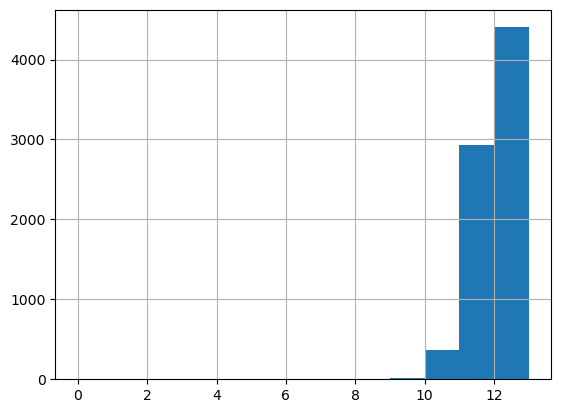

In [16]:
results.groupby('parameter_set')['is_steady_state'].sum().hist(bins=np.arange(0, 14, 1))

In [17]:
# Filter parameter sets for robustness in cyt_atp2adp
# Compute variability of cyt_atp2adp across perturbations for current robust_parameters
tolerance = 0.1  # maximum allowed variation in cyt_atp2adp
variability = results[results['parameter_set'].isin(robust_parameters)]\
    .groupby('parameter_set')['cyt_atp2adp']\
    .agg(lambda x: x.max() - x.min())
# Select parameter sets within tolerance
robust_cyt_sets = variability[variability < tolerance].index
# Update robust_parameters to include only those robust in cyt_atp2adp
robust_parameters = robust_parameters.intersection(robust_cyt_sets)

In [18]:
len(robust_parameters)

3109

In [19]:
from skimpy.core.parameters import ParameterValuePopulation
# Save the robust parameters
robust_parameter_population = ParameterValuePopulation([parameter_population[ix] for ix in robust_parameters], kmodel, robust_parameters, )
robust_parameter_population.save(tfa_sample_file.replace(".csv",'_robust_parameters.hdf5'))


In [20]:
# Filter the results 
results_filtered = results[results['parameter_set'].isin(robust_parameters)].reset_index()

Text(0, 0.5, 'ATP flux (umol/gDW/h)')

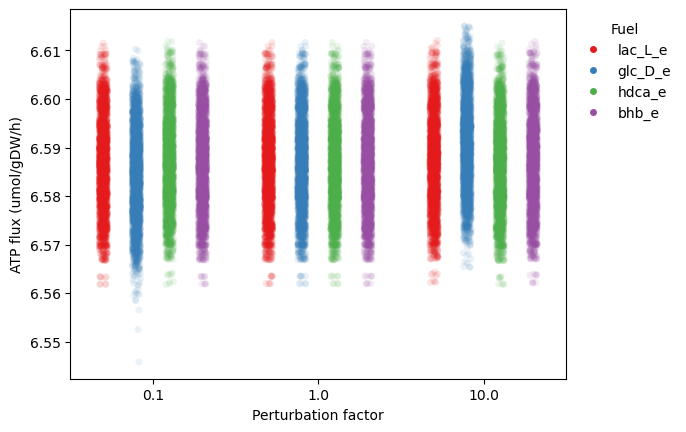

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(x='pertubration', y='cyt_atp2adp', data=results_filtered, hue='parameter',
          palette='Set1', dodge=True, alpha=0.1, legend=True)


# Make the legend opaque and outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
handles, labels = plt.gca().get_legend_handles_labels()
for i, h in enumerate(handles):
        h.set_alpha(1.0)
# Change the legend title
plt.legend(handles, labels, title='Fuel', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)


plt.xlabel('Perturbation factor')
plt.ylabel('ATP flux (umol/gDW/h)')



(0.0, 0.1)

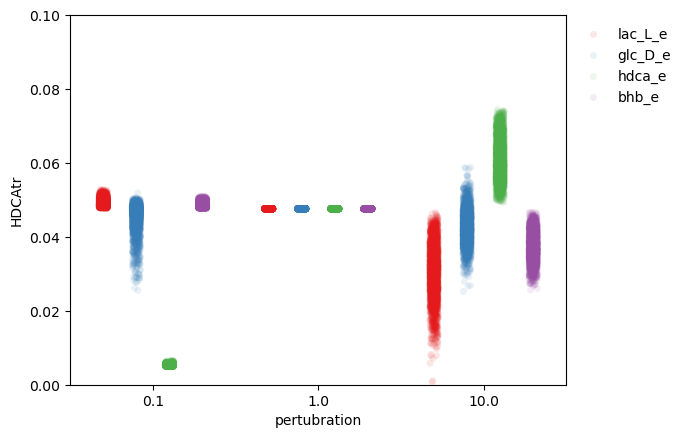

In [22]:
sns.stripplot(x='pertubration', y='HDCAtr', data=results_filtered, hue='parameter',
          palette='Set1', dodge=True, alpha=0.1, legend=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.ylim([0, 0.1])

<Axes: xlabel='pertubration', ylabel='BHBt'>

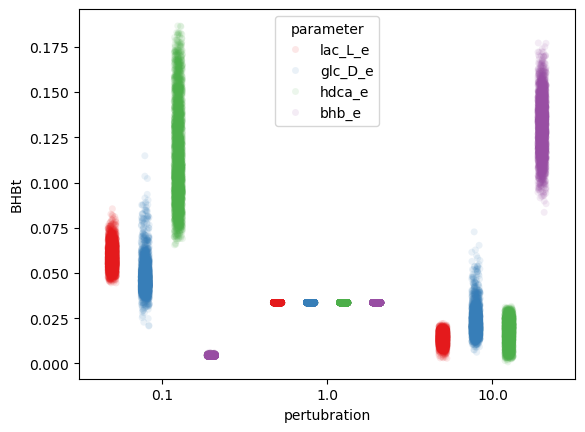

In [23]:
sns.stripplot(x='pertubration', y='BHBt', data=results_filtered, hue='parameter',
          palette='Set1', dodge=True, alpha=0.1, legend=True)

<Axes: xlabel='pertubration', ylabel='L_LACt2r'>

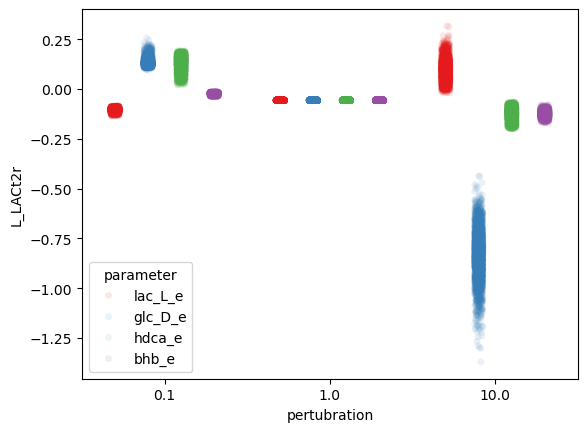

In [24]:
sns.stripplot(x='pertubration', y='L_LACt2r', data=results_filtered, hue='parameter',
          palette='Set1', dodge=True, alpha=0.1, legend=True)

<Axes: xlabel='pertubration', ylabel='GLCt1r'>

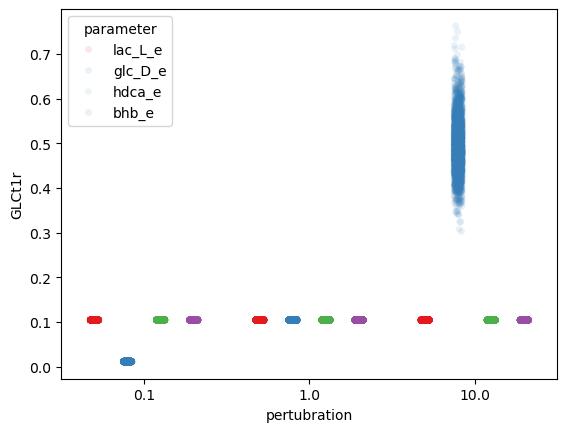

In [25]:
sns.stripplot(x='pertubration', y='GLCt1r', data=results_filtered, hue='parameter',
          palette='Set1', dodge=True, alpha=0.1, legend=True)

In [26]:
# Compute correlations
corr_fc = results[results_filtered.columns[:130]].astype(float).corr(method='pearson', numeric_only=True)


KeyError: "['index'] not in index"

In [ ]:
# Fetch only the correlation with respect to hdca_c, lac_L_c, glc_D_c, bhb_c
# 
corr_fc = corr_fc.loc[['hdca_c', 'lac_L_c', 'glc_D_c', 'bhb_c'], kmodel.variables.keys()]

In [ ]:
# Dictionary mapping variable names to descriptive biochemical annotations
variable_annotation_dict = {
    'coa_m': 'Coenzyme A (mito)',
    'aacoa_m': 'Acetoacetyl-CoA (mito)',
    'accoa_m': 'Acetyl-CoA (mito)',
    'icit_m': 'Isocitrate (mito)',
    'cit_m': 'Citrate (mito)',
    'adp_c': 'ADP (cyt)',
    'atp_c': 'ATP (cyt)',
    'amp_c': 'AMP (cyt)',
    'h_c': 'Proton (cyt)',
    'succoa_m': 'Succinyl-CoA (mito)',
    'nadh_m': 'NADH (mito)',
    'co2_m': 'CO₂ (mito)',
    'nad_m': 'NAD⁺ (mito)',
    'akg_m': 'α-Ketoglutarate (mito)',
    'mal_L_m': 'Malate (mito)',
    'akg_c': 'α-Ketoglutarate (cyt)',
    'mal_L_c': 'Malate (cyt)',
    'glu_L_m': 'Glutamate (mito)',
    'asp_L_c': 'Aspartate (cyt)',
    'glu_L_c': 'Glutamate (cyt)',
    'asp_L_m': 'Aspartate (mito)',
    'h_m': 'Proton (mito)',
    'psi_m_c': 'Membrane potential',
    'oaa_c': 'Oxaloacetate (cyt)',
    'oaa_m': 'Oxaloacetate (mito)',
    'atp_m': 'ATP (mito)',
    'pi_m': 'Phosphate (mito)',
    'adp_m': 'ADP (mito)',
    'acac_m': 'Acetoacetate (mito)',
    'bhb_m': '3-Hydroxybutyrate (mito)',
    'bhb_c': '3-Hydroxybutyrate (cyt)',
    'pmtcrn_c': 'Palmitoylcarnitine (cyt)',
    'coa_c': 'Coenzyme A (cyt)',
    'pmtcoa_c': 'Palmitoyl-CoA (cyt)',
    'crn_c': 'Carnitine (cyt)',
    'pmtcoa_m': 'Palmitoyl-CoA (mito)',
    'crn_m': 'Carnitine (mito)',
    'pmtcrn_m': 'Palmitoylcarnitine (mito)',
    'co2_c': 'CO₂ (cyt)',
    'ficytC_m': 'Cytochrome c (reduced, mito)',
    'o2_m': 'O₂ (mito)',
    'focytC_m': 'Cytochrome c (oxidized, mito)',
    'q10_m': 'Coenzyme Q10 (mito)',
    'q10h2_m': 'Coenzyme Q10H₂ (mito)',
    'pep_c': 'Phosphoenolpyruvate (cyt)',
    '_2pg_c': '2-Phosphoglycerate (cyt)',
    'ppi_c': 'Pyrophosphate (cyt)',
    'hdca_c': 'Palmitate (cyt)',
    'fad_m': 'FAD (mito)',
    'fadh2_m': 'FADH₂ (mito)',
    'g3p_c': 'Glycerol-3-phosphate (cyt)',
    'dhap_c': 'Dihydroxyacetone phosphate (cyt)',
    'fdp_c': 'Fructose-1,6-bisphosphate (cyt)',
    'fum_m': 'Fumarate (mito)',
    'nadh_c': 'NADH (cyt)',
    'nad_c': 'NAD⁺ (cyt)',
    'glyc3p_c': 'Glyceraldehyde-3-phosphate (cyt)',
    '_13dpg_c': '1,3-Bisphosphoglycerate (cyt)',
    'glc_D_c': 'Glucose (cyt)',
    'g6p_c': 'Glucose-6-phosphate (cyt)',
    'pyr_c': 'Pyruvate (cyt)',
    'lac_L_c': 'Lactate (cyt)',
    'pyr_m': 'Pyruvate (mito)',
    'lac_L_m': 'Lactate (mito)',
    'gtp_m': 'GTP (mito)',
    'gdp_m': 'GDP (mito)',
    'o2_c': 'O₂ (cyt)',
    'succ_m': 'Succinate (mito)',
    'f6p_c': 'Fructose-6-phosphate (cyt)',
    '_3pg_c': '3-Phosphoglycerate (cyt)'
}

In [ ]:
# Name the variables in the correlation matrix
corr_fc = corr_fc.rename(columns=variable_annotation_dict)

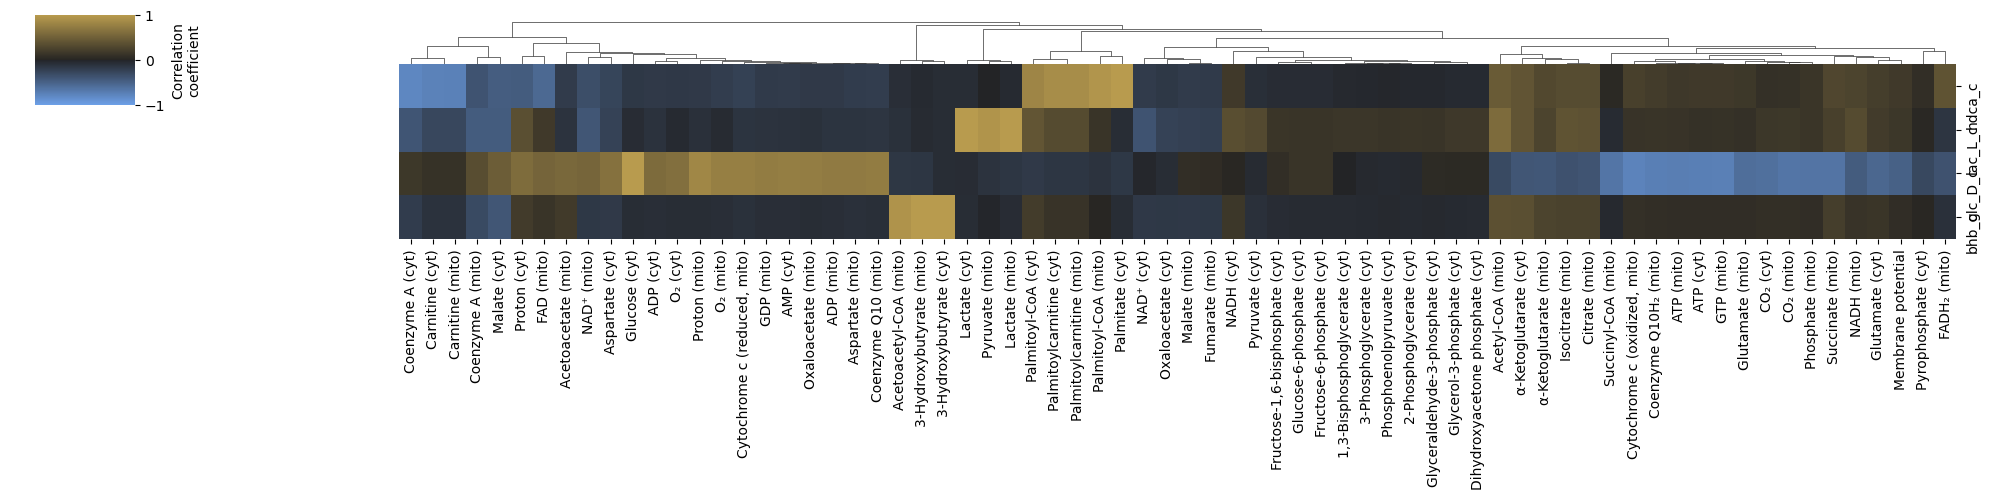

In [ ]:

# Cluster the correlations
import seaborn as sns

# Make the right yellow - 30 -> 
cmap = sns.diverging_palette(250, 65, l=65, center="dark", as_cmap=True)

sns.clustermap(corr_fc, center=0, figsize=(20, 5), cmap=cmap,
               annot=False, fmt='.2f', vmin=-1, vmax=1,
               cbar_kws={"label": "Correlation\ncoefficient"},
                row_cluster=False, col_cluster=True, 
                xticklabels=True, yticklabels=True)
